In [7]:
import networkx as nx
import pgmpy
from IPython.display import Image

Example of using Networkx to imput network

In [8]:
G = nx.DiGraph()
G.add_node(1)
G.add_nodes_from([2,3,4])
G.node[1]['probability'] = [1,2,3]
G.nodes(data="true")
G.add_edge(1,2)

G.nodes(data="true")

[(1, {'probability': [1, 2, 3]}), (2, {}), (3, {}), (4, {})]

We switch to tool pgmpy since it is based on Networkx and can compute conditional probability table directly from the model

** Example: Monte Hall problem**

In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining the network structure
model = BayesianModel([('C', 'H'), ('P', 'H')])

# Defining the CPDs:
cpd_c = TabularCPD('C', 3, [[0.33, 0.33, 0.33]])
cpd_p = TabularCPD('P', 3, [[0.33, 0.33, 0.33]])
cpd_h = TabularCPD('H', 3, [[0, 0, 0, 0, 0.5, 1, 0, 1, 0.5], 
                            [0.5, 0, 1, 0, 0, 0, 1, 0, 0.5], 
                            [0.5, 1, 0, 1, 0.5, 0, 0, 0, 0]],
                  evidence=['C', 'P'], evidence_card=[3, 3])

# Associating the CPDs with the network structure.
model.add_cpds(cpd_c, cpd_p, cpd_h)

# Some other methods
model.get_cpds()

[<TabularCPD representing P(C:3) at 0x2e2ca47d8d0>,
 <TabularCPD representing P(P:3) at 0x2e2ca487710>,
 <TabularCPD representing P(H:3 | C:3, P:3) at 0x2e2cb977f98>]

Calculate the probabitlity given C and H

In [10]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
posterior_p = infer.query(['P'], evidence={'C': 0, 'H': 2})
print(posterior_p['P'])

╒═════╤══════════╕
│ P   │   phi(P) │
╞═════╪══════════╡
│ P_0 │   0.3333 │
├─────┼──────────┤
│ P_1 │   0.6667 │
├─────┼──────────┤
│ P_2 │   0.0000 │
╘═════╧══════════╛


** Example: China Default**

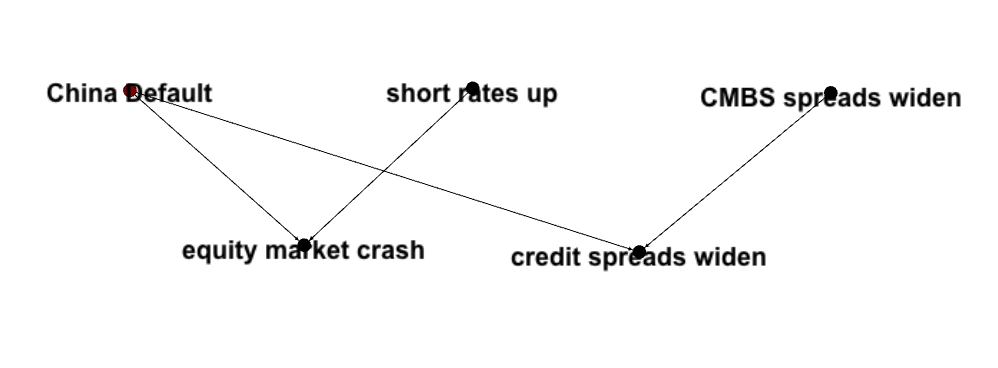

In [11]:
Image('China defaults example.png')

In [12]:
#Let C1 be the event that China default
#    C2 be the event that short rates up
#    C3 be the event that CMBS spreads widen
#    E1 be equity market crash
#    E2 be credit spreads widen

model = BayesianModel([('C1','E1'),('C2','E1'),('C1','E2'),('C3','E2')])

#define conditional probabilities of C1, C2 and C3
cpd_c1 = TabularCPD(variable='C1', variable_card=2, values=[[0.9, 0.1]])
cpd_c2 = TabularCPD(variable='C2', variable_card=2, values=[[0.5, 0.5]])
cpd_c3 = TabularCPD(variable='C3', variable_card=2, values=[[0.5, 0.5]])

#define the conditional probabilities of E1 and E2
#Take E1 as example
#    +---------+---------+---------+---------+---------+
#    |         | C1 =  0 | C1 = 0  | C1 = 1  | C1 = 1  |
#    +---------+---------+---------+---------+---------+
#    |         | C2 = 0  | C2 = 1  | C2 = 0  | C2 = 1  |
#    +---------+---------+---------+---------+---------+
#    | E1 = 0  | 0.9     | 0.7     | 0.2     | 0.05    |
#    +---------+---------+---------+---------+---------+
#    | E1 = 1  | 0.1     | 0.3     | 0.8     | 0.95    |
#    +---------+---------+---------+---------+---------+


cpd_e1 = TabularCPD(variable = 'E1',variable_card = 2, values = [[0.9,0.7,0.2,0.05],
                                                                 [0.1,0.3,0.8,0.95]],
                                                                 evidence = ['C1','C2'],
                                                                 evidence_card = [2,2])
                
cpd_e2 = TabularCPD(variable = 'E2',variable_card = 2, values = [[0.9,0.4,0.35,0.15],
                                                                 [0.1,0.6,0.65,0.85]],
                                                                 evidence = ['C1','C3'],
                                                                 evidence_card = [2,2])

model.add_cpds(cpd_c1,cpd_c2,cpd_c3,cpd_e1,cpd_e2)

model.check_model()

True

In [13]:
#We can print the probability table by calling

print(model.get_cpds('E1'))

╒══════╤══════╤══════╤══════╤══════╕
│ C1   │ C1_0 │ C1_0 │ C1_1 │ C1_1 │
├──────┼──────┼──────┼──────┼──────┤
│ C2   │ C2_0 │ C2_1 │ C2_0 │ C2_1 │
├──────┼──────┼──────┼──────┼──────┤
│ E1_0 │ 0.9  │ 0.7  │ 0.2  │ 0.05 │
├──────┼──────┼──────┼──────┼──────┤
│ E1_1 │ 0.1  │ 0.3  │ 0.8  │ 0.95 │
╘══════╧══════╧══════╧══════╧══════╛


In [14]:
# We can also check the independencies by using 
model.local_independencies('E1')

(E1 _|_ E2, C3 | C1, C2)

In [15]:
#We can further make inference on the model
infer = VariableElimination(model)
print(infer.query(['E1'])['E1'])

╒══════╤═══════════╕
│ E1   │   phi(E1) │
╞══════╪═══════════╡
│ E1_0 │    0.7325 │
├──────┼───────────┤
│ E1_1 │    0.2675 │
╘══════╧═══════════╛


In [16]:
#If we have some observation, we can change the query by having
print(infer.query(['E1'],evidence = {'C1':1})['E1'])

╒══════╤═══════════╕
│ E1   │   phi(E1) │
╞══════╪═══════════╡
│ E1_0 │    0.1250 │
├──────┼───────────┤
│ E1_1 │    0.8750 │
╘══════╧═══════════╛


Now we try to analyze what will happen to the stock markets and commodity markets in asia when North Korea missile crisis breaks out. 

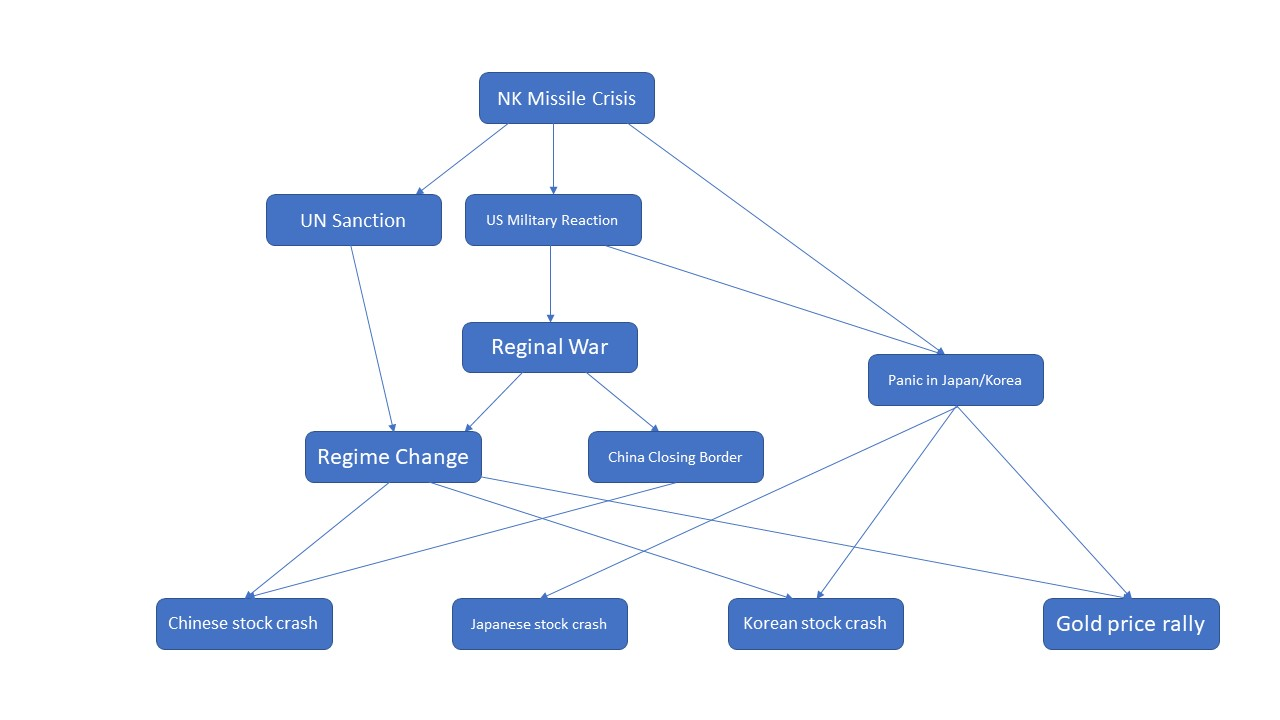

In [17]:
Image('North Korea.jpg')

In [24]:
#Let C0 be the event that North Korea fires a missile
#    C1 be the event of UN sanction 
#    C2 be the event that US deploys military reaction
#    C3 be panic in Japan and Korea
#    C4 be a reginal war between US and North Korea
#    C5 be a regime change in NK
#    C6 be the event that china closing down border
#    E1 be the event that Chinese stock market crash
#    E2 be the event that Japanese stock market crash
#    E3 be that Korean stock market crash
#    E4 be that gold price rally

model = BayesianModel([('C0','C1'),('C0','C2'),('C0','C3'),('C2','C3'),('C2','C4'),('C4','C5'),('C1','C4'),
                                                ('C4','C6'),('C1','C5'),('C5','E1'),('C5','E3'),
                                                ('C5','E4'),('C6','E1'),('C3','E2'),('C3','E3'),('C3','E4')])

cpd_c0 = TabularCPD(variable='C0', variable_card=2, values=[[0.9, 0.1]])


cpd_c1 = TabularCPD(variable = 'C1',variable_card = 2, values = [[0.2,0.9],
                                                                 [0.8,0.1]],
                                                                 evidence = ['C0'],
                                                                 evidence_card = [2])
                
cpd_c2 = TabularCPD(variable = 'C2',variable_card = 2, values = [[0.2,0.9],
                                                                 [0.8,0.1]],
                                                                 evidence = ['C0'],
                                                                 evidence_card = [2])
                       
cpd_c3 = TabularCPD(variable = 'C3',variable_card = 2, values = [[0.8,0.6,0.1,0.2],
                                                                 [0.2,0.4,0.9,0.8]],
                                                                 evidence = ['C0','C2'],
                                                                 evidence_card = [2,2])  
                       
cpd_c4 = TabularCPD(variable = 'C4',variable_card = 2, values = [[0.9,0.4,0.7,0.2],
                                                                 [0.1,0.6,0.3,0.8]],
                                                                 evidence = ['C1','C2'],
                                                                 evidence_card = [2,2])
                       
cpd_c5 = TabularCPD(variable = 'C5',variable_card = 2, values = [[0.9,0.1,0.7,0.02],
                                                                 [0.1,0.9,0.3,0.98]],
                                                                 evidence = ['C1','C4'],
                                                                 evidence_card = [2,2])
                       
cpd_c6 = TabularCPD(variable = 'C6',variable_card = 2, values = [[0.99,0.2],
                                                                 [0.01,0.8]],
                                                                 evidence = ['C4'],
                                                                 evidence_card = [2])

cpd_e1 = TabularCPD(variable = 'E1',variable_card = 2, values = [[0.9,0.4,0.2,0.1],
                                                                 [0.1,0.6,0.8,0.9]],
                                                                 evidence = ['C6','C5'],
                                                                 evidence_card = [2,2])

cpd_e2 = TabularCPD(variable = 'E2',variable_card = 2, values = [[0.9,0.1],
                                                                 [0.1,0.9]],
                                                                 evidence = ['C3'],
                                                                 evidence_card = [2])       

cpd_e3 = TabularCPD(variable = 'E3',variable_card = 2, values = [[0.9,0.3,0.3,0.1],
                                                                 [0.1,0.7,0.7,0.9]],
                                                                 evidence = ['C5','C3'],
                                                                 evidence_card = [2,2])
                                                                 
cpd_e4 = TabularCPD(variable = 'E4',variable_card = 2, values = [[0.9,0.4,0.2,0.1],
                                                                 [0.1,0.6,0.8,0.9]],
                                                                 evidence = ['C5','C3'],
                                                                 evidence_card = [2,2])                                                                 

                       
model.add_cpds(cpd_c0,cpd_c1,cpd_c2,cpd_c3,cpd_c4,cpd_c5,cpd_c6,cpd_e1,cpd_e2,cpd_e3,cpd_e4)

model.check_model()

True

In [25]:
infer = VariableElimination(model)
print(infer.query(['E1'])['E1'])
print(infer.query(['E2'])['E2'])
print(infer.query(['E3'])['E3'])
print(infer.query(['E4'])['E4'])

╒══════╤═══════════╕
│ E1   │   phi(E1) │
╞══════╪═══════════╡
│ E1_0 │    0.4075 │
├──────┼───────────┤
│ E1_1 │    0.5925 │
╘══════╧═══════════╛
╒══════╤═══════════╕
│ E2   │   phi(E2) │
╞══════╪═══════════╡
│ E2_0 │    0.5696 │
├──────┼───────────┤
│ E2_1 │    0.4304 │
╘══════╧═══════════╛
╒══════╤═══════════╕
│ E3   │   phi(E3) │
╞══════╪═══════════╡
│ E3_0 │    0.3542 │
├──────┼───────────┤
│ E3_1 │    0.6458 │
╘══════╧═══════════╛
╒══════╤═══════════╕
│ E4   │   phi(E4) │
╞══════╪═══════════╡
│ E4_0 │    0.3281 │
├──────┼───────────┤
│ E4_1 │    0.6719 │
╘══════╧═══════════╛


In [30]:
print(infer.query(['E1'],evidence={'C0':1})['E1'])
print(infer.query(['E2'],evidence={'C0':1})['E2'])
print(infer.query(['E3'],evidence={'C0':1})['E3'])
print(infer.query(['E4'],evidence={'C0':1})['E4'])


╒══════╤═══════════╕
│ E1   │   phi(E1) │
╞══════╪═══════════╡
│ E1_0 │    0.7233 │
├──────┼───────────┤
│ E1_1 │    0.2767 │
╘══════╧═══════════╛
╒══════╤═══════════╕
│ E2   │   phi(E2) │
╞══════╪═══════════╡
│ E2_0 │    0.1880 │
├──────┼───────────┤
│ E2_1 │    0.8120 │
╘══════╧═══════════╛
╒══════╤═══════════╕
│ E3   │   phi(E3) │
╞══════╪═══════════╡
│ E3_0 │    0.3031 │
├──────┼───────────┤
│ E3_1 │    0.6969 │
╘══════╧═══════════╛
╒══════╤═══════════╕
│ E4   │   phi(E4) │
╞══════╪═══════════╡
│ E4_0 │    0.3670 │
├──────┼───────────┤
│ E4_1 │    0.6330 │
╘══════╧═══════════╛
